In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../../../code/statistical_analysis/extinction_analysis/")
from simulator import Simulator, ExtinctionOrder

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=40, use_memory_fs=False)

import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import auc
import seaborn as sns
import scipy.stats as stats

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
rewiring_prob=0.5
sim_num=100


sim_types= ["random", "polyploids_first", "diploids_first"]
working_dir = f"../../../data/statistical_analysis/extinction_analysis/rewiring_prob_{rewiring_prob}/"
extinction_simluations_output_path = {sim_type: f"{working_dir}/rewiring_prob_{rewiring_prob}_united_{sim_type}_order_extinction_simulations.csv" for sim_type in sim_types}
weighted_features_data = "../../../data/features/plant/weighted/features_with_classification.csv"
binary_features_data = "../../../data/features/plant/binary/features_with_classification.csv"
binarized_features_data = "../../../data/features/plant/binarized_weighted/features_with_classification.csv"
num_poly_threshold = 2
num_di_threshold = 2

all_networks_path = "../../../data/networks/all/"
binary_networks_path = f"{all_networks_path}binary/"
weighted_networks_path = f"{all_networks_path}weighted/"
binarized_networks_path = f"{all_networks_path}binarized_weighted/"

networks = {'weighted': {'networks': weighted_networks_path, 'data': weighted_features_data},
            'binary': {'networks': binary_networks_path, 'data': binary_features_data},
            'binarized_weighted': {'networks': binarized_networks_path, 'data': binarized_features_data}}

networks_classification_data_paths = ["../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_unweighted_networks.csv",
                                     "../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_weighted_networks.csv"]
robustness_data_path = f"{working_dir}robustness_data.csv"
aggregated_robustness_data_path = f"../../../data/statistical_analysis/extinction_analysis/rewiring_prob_{rewiring_prob}_aggregated_robustness_data.csv"

In [3]:
first_poly_extinction_data = pd.read_csv(extinction_simluations_output_path["polyploids_first"])
first_di_extinction_data = pd.read_csv(extinction_simluations_output_path["diploids_first"])
random_extinction_data = pd.read_csv(extinction_simluations_output_path["random"])

In [4]:
def get_robustness_measures(df: pd.DataFrame) -> pd.Series:
    return df.groupby(["network_type", "network", "simulation_index"]).parallel_apply(lambda df: auc(df.prop_primary_extinctions, df.prop_secondary_survival))

In [5]:
first_poly_robustness_values = get_robustness_measures(df=first_poly_extinction_data)

In [6]:
first_di_robustness_values = get_robustness_measures(df=first_di_extinction_data)

In [7]:
random_robustness_values = get_robustness_measures(df=random_extinction_data)

In [8]:
first_poly_robustness_values = first_poly_robustness_values.to_frame().sort_index().rename(columns={0: "first_poly_robustness"})
first_di_robustness_values = first_di_robustness_values.to_frame().sort_index().rename(columns={0: "first_di_robustness"})
random_robustness_values = random_robustness_values.to_frame().sort_index().rename(columns={0: "random_robustness"})

In [9]:
robustness_values = first_poly_robustness_values.join(random_robustness_values)
robustness_values = robustness_values.join(first_di_robustness_values)

In [10]:
robustness_values = robustness_values.reset_index()

In [11]:
networks_classification_data = pd.concat([pd.read_csv(path) for path in networks_classification_data_paths])

In [12]:
networks_classification_data.network_id = networks_classification_data.network_id.apply(lambda x: int(x.split("_")[0]))

In [13]:
robustness_values = robustness_values.rename(columns={"network": "network_id"})

In [14]:
# add % polyploids
robustness_values = robustness_values.merge(networks_classification_data[["network_type", "network_id", "network_size", "pd",
                                                                          "is_polyploid_poly_frac", "is_polyploid_missing_frac",
                                                                          "num_polyploids", "num_diploids", "num_classified"]], on=["network_type", "network_id"])

In [16]:
robustness_values.isna().sum() / robustness_values.shape[0]

network_type                 0.0
network_id                   0.0
simulation_index             0.0
first_poly_robustness        0.0
random_robustness            0.0
first_di_robustness          0.0
network_size                 0.0
pd                           0.0
is_polyploid_poly_frac       0.0
is_polyploid_missing_frac    0.0
num_polyploids               0.0
num_diploids                 0.0
num_classified               0.0
dtype: float64

In [17]:
robustness_values.to_csv(robustness_data_path)

In [18]:
agg_robustness_values = robustness_values.dropna().groupby(["network_type", "network_id"])[["first_poly_robustness", "first_di_robustness", "random_robustness",
                                                                                           "is_polyploid_poly_frac", "is_polyploid_missing_frac", 
                                                                                            "num_polyploids", "num_diploids", "num_classified",
                                                                                            "pd", "network_size"]].mean()

In [19]:
agg_robustness_values.reset_index().to_csv(aggregated_robustness_data_path)

In [20]:
assert(min(robustness_values.first_poly_robustness) >= 0)
assert(min(robustness_values.first_di_robustness) >= 0)
assert(min(robustness_values.random_robustness) >= 0)

assert(max(robustness_values.first_poly_robustness) <= 1)
assert(max(robustness_values.first_di_robustness) <= 1)
assert(max(robustness_values.random_robustness) <= 1)

In [21]:
first_di_extinction_data.head()

,Unnamed: 0,network_type,network,simulation_index,primary_iteration,cascade_iteration,extinction_type,extinction_level,extinct_taxon,n_plants,n_pollinators,prop_primary_extinctions,prop_secondary_extinctions,prop_secondary_survival
0,0,binarized_weighted,0,0,1,1,primary,plant,Aristotelia chilensis,9,19,0.1,0.000000,1.000000
1,1,binarized_weighted,0,0,2,1,primary,plant,Vicia nigricans,8,19,0.2,0.000000,1.000000
2,2,binarized_weighted,0,0,3,1,primary,plant,Mutisia decurrens,7,19,0.3,0.000000,1.000000
3,3,binarized_weighted,0,0,3,2,secondary,pollinator,Lauxaniidae,7,18,0.3,0.052632,0.947368
4,4,binarized_weighted,0,0,4,1,primary,plant,Tristerix corymbosus,6,18,0.4,0.052632,0.947368


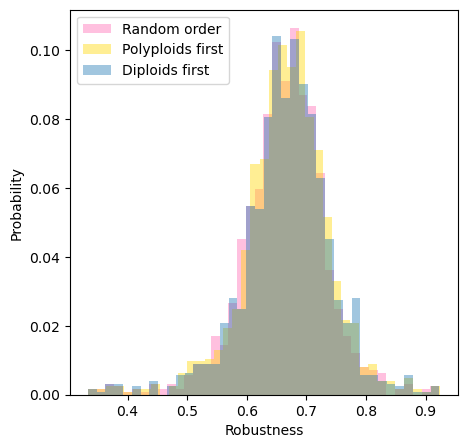

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "gold" #"tab:orange" # yellow, pink, blue
di_color = "tab:blue"
random_color = "hotpink" #"tab:grey"
alpha = 0.42


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.histplot(agg_robustness_values.random_robustness, label="Random order", color=random_color, ax=ax, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(agg_robustness_values.first_poly_robustness, label="Polyploids first", color=poly_color, ax=ax, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(agg_robustness_values.first_di_robustness, label="Diploids first", ax=ax, color=di_color, stat="probability", alpha=alpha, linewidth=0)

ax.set_xlabel("Robustness")

ax.legend()

fig.savefig(f"../../../data/figures/fig5_rewiring_prob_{rewiring_prob}.jpeg")